## Project: FactoryGuard-AI
### Dataset: [NASA C-MAPSS-1 Turbofan Engine Degradation](https://www.kaggle.com/datasets/bishals098/nasa-turbofan-engine-degradation-simulation)
#### Week 2: Modeling and Imbalance Handling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_df=pd.read_csv("/mnt/f/Zaalima Internship/Zaalima Project/factoryguard-ai/data/processed/processed_data.csv")
train_df

,engine_id,cycle,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,...,sensor_9_ema_12,sensor_11_ema_12,sensor_12_ema_12,sensor_13_ema_12,sensor_14_ema_12,sensor_15_ema_12,sensor_17_ema_12,sensor_20_ema_12,sensor_21_ema_12,label_24
0,1,12,642.06,1583.41,1400.15,554.52,2388.09,9049.37,47.18,521.80,...,9049.579221,47.211608,521.938474,2388.035130,8133.076871,8.408378,391.769252,38.992928,23.401434,0
1,1,13,643.07,1582.19,1400.83,553.44,2388.12,9046.82,47.38,521.85,...,9049.100115,47.240847,521.923112,2388.042921,8132.212697,8.409562,391.982957,38.982001,23.379602,0
2,1,14,642.35,1592.95,1399.16,554.48,2388.09,9047.37,47.44,521.67,...,9048.805532,47.274756,521.880015,2388.035613,8132.590233,8.407321,392.156127,39.015714,23.380112,0
3,1,15,642.43,1583.82,1402.13,553.64,2388.11,9052.22,47.30,522.50,...,9049.377514,47.278985,521.983873,2388.043048,8131.747583,8.409428,391.962456,39.011407,23.375068,0
4,1,16,642.13,1587.98,1404.50,553.94,2388.05,9049.34,47.24,521.49,...,9049.371314,47.272543,521.902257,2388.047502,8132.468507,8.406813,391.968660,39.004564,23.388277,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19526,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,...,9066.884787,48.085490,519.920653,2388.235148,8141.022486,8.510795,395.759712,38.441959,23.096156,1
19527,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,...,9066.611742,48.078491,519.883630,2388.232817,8140.326719,8.511273,395.642833,38.420119,23.105886,1
19528,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,...,9066.502244,48.080262,519.903071,2388.233922,8140.437993,8.519477,396.005474,38.423177,23.079334,1
19529,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,...,9067.612668,48.127914,519.867214,2388.233319,8140.261379,8.522465,395.850786,38.402689,23.076975,1


In [3]:
train_df.columns.to_list()

['engine_id',
 'cycle',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_17',
 'sensor_20',
 'sensor_21',
 'max_cycle',
 'RUL',
 'sensor_2_lag_1',
 'sensor_2_lag_2',
 'sensor_3_lag_1',
 'sensor_3_lag_2',
 'sensor_4_lag_1',
 'sensor_4_lag_2',
 'sensor_7_lag_1',
 'sensor_7_lag_2',
 'sensor_8_lag_1',
 'sensor_8_lag_2',
 'sensor_9_lag_1',
 'sensor_9_lag_2',
 'sensor_11_lag_1',
 'sensor_11_lag_2',
 'sensor_12_lag_1',
 'sensor_12_lag_2',
 'sensor_13_lag_1',
 'sensor_13_lag_2',
 'sensor_14_lag_1',
 'sensor_14_lag_2',
 'sensor_15_lag_1',
 'sensor_15_lag_2',
 'sensor_17_lag_1',
 'sensor_17_lag_2',
 'sensor_20_lag_1',
 'sensor_20_lag_2',
 'sensor_21_lag_1',
 'sensor_21_lag_2',
 'sensor_2_mean_1',
 'sensor_3_mean_1',
 'sensor_4_mean_1',
 'sensor_7_mean_1',
 'sensor_8_mean_1',
 'sensor_9_mean_1',
 'sensor_11_mean_1',
 'sensor_12_mean_1',
 'sensor_13_mean_1',
 'sensor_14_mean_1',
 'sensor_15_

In [4]:
train_df["label_24"].value_counts()

label_24
0    17031
1     2500
Name: count, dtype: int64

In [5]:
train_df.drop(["cycle","max_cycle","RUL"],axis="columns",inplace=True) # dropping since these columns directly reflect label_24

In [6]:
x=train_df.drop("label_24",axis="columns")
y=train_df['label_24']

## Feature Selection

In [7]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import average_precision_score,roc_auc_score

groups=x["engine_id"]

X=x.drop("engine_id",axis="columns")


skf=StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=32)

importances=np.zeros(X.shape[1])

pr=[]
ro=[]

for fold,(train_idx,test_idx) in enumerate(skf.split(X,y,groups=groups)):
    x_train,y_train=X.iloc[train_idx],y.iloc[train_idx]
    x_test,y_test=X.iloc[test_idx],y.iloc[test_idx]

    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()

    model=LGBMClassifier(importance_type="gain",scale_pos_weight=scale_pos_weight,random_state=32)
    model.fit(x_train,y_train)

    y_pred_proba=model.predict_proba(x_test)[:,1]
    p=average_precision_score(y_test,y_pred_proba)
    r=roc_auc_score(y_test,y_pred_proba)
    pr.append(p)
    ro.append(r)
    importances+=model.feature_importances_*p
    print(f"Fold {fold} has PR Score: {p}, ROC Score: {r}")

importances/=sum(pr)


[LightGBM] [Info] Number of positive: 2000, number of negative: 13735
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24434
[LightGBM] [Info] Number of data points in the train set: 15735, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127105 -> initscore=-1.926800
[LightGBM] [Info] Start training from score -1.926800
Fold 0 has PR Score: 0.9543442786562483, ROC Score: 0.9917858009708738
[LightGBM] [Info] Number of positive: 2000, number of negative: 13756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24436
[LightGBM] [Info] Number of data points in the train set: 15756, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126936 -> initscore=-1.

In [8]:
important_df=pd.DataFrame({"columns":X.columns,"importance":importances})
important_df

,columns,importance
0,sensor_2,192.114736
1,sensor_3,148.539889
2,sensor_4,158.225831
3,sensor_7,163.040771
4,sensor_8,121.745804
...,...,...
107,sensor_14_ema_12,189.382022
108,sensor_15_ema_12,29764.621215
109,sensor_17_ema_12,32518.340636
110,sensor_20_ema_12,391.933204


In [16]:
important_df=important_df[important_df["importance"]>important_df["importance"].quantile(0.50)]
important_df

,columns,importance
5,sensor_9,631.796878
9,sensor_14,590.762312
24,sensor_9_lag_1,1627.633707
25,sensor_9_lag_2,1033.607527
32,sensor_14_lag_1,354.962470
33,sensor_14_lag_2,546.108207
56,sensor_2_mean_6,2390.164452
57,sensor_2_std_6,525.273014
58,sensor_3_mean_6,701.624724
59,sensor_3_std_6,324.727627


In [17]:
len(important_df)

56

In [15]:
pr, ro

([0.9543442786562483,
  0.9483571835828571,
  0.9600625297508277,
  0.9432190526920481,
  0.9416651560650607],
 [0.9917858009708738,
  0.9900653435114504,
  0.9931351197263398,
  0.9893268737532062,
  0.9895567818762707])

In [18]:
X=X[important_df["columns"].values]
X

,sensor_9,sensor_14,sensor_9_lag_1,sensor_9_lag_2,sensor_14_lag_1,sensor_14_lag_2,sensor_2_mean_6,sensor_2_std_6,sensor_3_mean_6,sensor_3_std_6,...,sensor_2_ema_12,sensor_3_ema_12,sensor_7_ema_12,sensor_8_ema_12,sensor_9_ema_12,sensor_11_ema_12,sensor_15_ema_12,sensor_17_ema_12,sensor_20_ema_12,sensor_21_ema_12
0,9049.37,8134.25,9049.61,9051.70,8140.58,8129.38,642.201667,0.309995,1587.110000,4.874833,...,642.173927,1586.268249,554.177512,2388.052773,9049.579221,47.211608,8.408378,391.769252,38.992928,23.401434
1,9046.82,8128.10,9049.37,9049.61,8134.25,8140.58,642.300000,0.468828,1585.421667,4.444761,...,642.329519,1585.560110,554.049452,2388.064447,9049.100115,47.240847,8.409562,391.982957,38.982001,23.379602
2,9047.37,8134.43,9046.82,9049.37,8128.10,8134.25,642.265000,0.453111,1587.086667,5.152905,...,642.333006,1586.818372,554.122760,2388.068797,9048.805532,47.274756,8.407321,392.156127,39.015714,23.380112
3,9052.22,8127.56,9047.37,9046.82,8134.43,8128.10,642.316667,0.450940,1585.893333,4.893484,...,642.349254,1586.316093,554.041890,2388.075700,9049.377514,47.278985,8.409428,391.962456,39.011407,23.375068
4,9049.34,8136.11,9052.22,9047.37,8127.56,8134.43,642.386667,0.361700,1585.350000,4.329596,...,642.313021,1586.591067,554.025052,2388.071453,9049.371314,47.272543,8.406813,391.968660,39.004564,23.388277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19526,9065.52,8137.60,9069.69,9068.85,8142.90,8139.67,643.488333,0.228422,1601.203333,4.948615,...,643.442577,1599.242283,551.624918,2388.218266,9066.884787,48.085490,8.510795,395.759712,38.441959,23.096156
19527,9065.11,8136.50,9065.52,9069.69,8137.60,8142.90,643.463333,0.209348,1600.141667,2.573118,...,643.457565,1600.051163,551.507238,2388.220071,9066.611742,48.078491,8.511273,395.642833,38.420119,23.105886
19528,9065.90,8141.05,9065.11,9065.52,8136.50,8137.60,643.445000,0.207147,1600.346667,2.721865,...,643.451786,1600.421753,551.419971,2388.223137,9066.502244,48.080262,8.519477,396.005474,38.423177,23.079334
19529,9073.72,8139.29,9065.90,9065.11,8141.05,8136.50,643.468333,0.162162,1601.255000,3.345001,...,643.417665,1601.166099,551.306129,2388.227270,9067.612668,48.127914,8.522465,395.850786,38.402689,23.076975


In [20]:
from sklearn.model_selection import GroupShuffleSplit

gss=GroupShuffleSplit(n_splits=1,test_size=0.3,random_state=42)

train_idx,test_idx=next(gss.split(X,y,groups=groups))

x_train,y_train=X.iloc[train_idx],y.iloc[train_idx]
x_test,y_test=X.iloc[test_idx],y.iloc[test_idx]


In [21]:
print(y_train.mean(),y_test.mean())

0.12739317172599549 0.12944425267518123


### Base-Line model : Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
y_train.value_counts(),y_test.value_counts()

(label_24
 0    11987
 1     1750
 Name: count, dtype: int64,
 label_24
 0    5044
 1     750
 Name: count, dtype: int64)

Since the dataset is imbalanced and prediction of minority class is our business objective, We'll be focusing following metrics in this priority
- **Precision-Recall score (average_precision)** to focus on miniority desired class which represents failure
- **Recall** to capture early failure in engines
- **Precision** defines model's accuracy in correctly identifying failue engines

In [24]:
base_model=RandomForestClassifier(class_weight="balanced_subsample",random_state=32) # usage of class weight to mitigate imbalance
base_model.fit(x_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
from sklearn.metrics import average_precision_score,classification_report

y_base_pred_proba=base_model.predict_proba(x_test)[:,1]
y_base_pred=base_model.predict(x_test)

base_pr=average_precision_score(y_test,y_base_pred_proba)

print("AVG. PR Score: ",base_pr)
print("---")
print(classification_report(y_test,y_base_pred))
print("---")
print("ROC AUC Score: ",roc_auc_score(y_test,y_base_pred_proba))

AVG. PR Score:  0.948107311505406
---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5044
           1       0.89      0.85      0.87       750

    accuracy                           0.97      5794
   macro avg       0.93      0.92      0.92      5794
weighted avg       0.97      0.97      0.97      5794

---
ROC AUC Score:  0.9898273856727465


### Production Model: LightGBM

In [29]:
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum() # computing class weight
scale_pos_weight

6.849714285714286

In [30]:
from lightgbm import LGBMClassifier

final_model=LGBMClassifier(scale_pos_weight=scale_pos_weight,random_state=32)

final_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 1750, number of negative: 11987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13799
[LightGBM] [Info] Number of data points in the train set: 13737, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127393 -> initscore=-1.924207
[LightGBM] [Info] Start training from score -1.924207


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [33]:
# Final model Metrics
y_final_pred=final_model.predict(x_test)
y_final_pred_proba=final_model.predict_proba(x_test)[:,1]

final_pr=average_precision_score(y_test,y_final_pred_proba)

print("Final PR score: ",final_pr)
print("---")
print(classification_report(y_test,y_final_pred))
print("Final ROC AUC Score: ",roc_auc_score(y_test,y_final_pred_proba))

Final PR score:  0.9542840946856155
---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5044
           1       0.84      0.90      0.87       750

    accuracy                           0.96      5794
   macro avg       0.91      0.94      0.92      5794
weighted avg       0.97      0.96      0.97      5794

Final ROC AUC Score:  0.9909429024583664


In [36]:
print(final_pr>base_pr )    # This confirms the final model outperforms the baseline
print(roc_auc_score(y_test,y_final_pred_proba)>roc_auc_score(y_test,y_base_pred_proba))

True
True


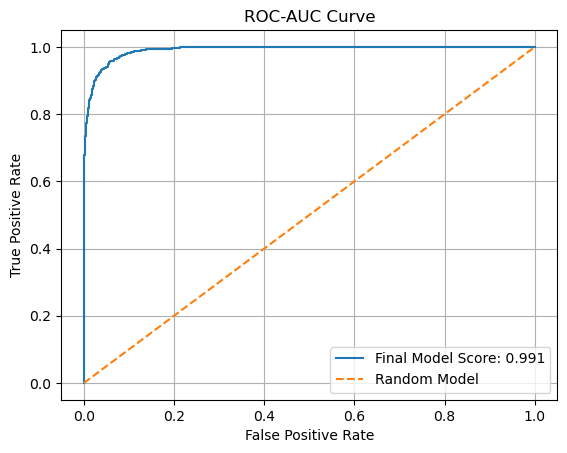

In [37]:
from sklearn.metrics import roc_curve,f1_score,fbeta_score,precision_score,recall_score,roc_auc_score

fpr,tpr,threshold=roc_curve(y_test,y_final_pred_proba)

plt.plot(fpr,tpr,label=f"Final Model Score: {round(roc_auc_score(y_test,y_final_pred_proba),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],label="Random Model",linestyle="--")
plt.title("ROC-AUC Curve")
plt.grid(True)
plt.legend()
plt.show()

/home/abhi/miniforge3/envs/tf_gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


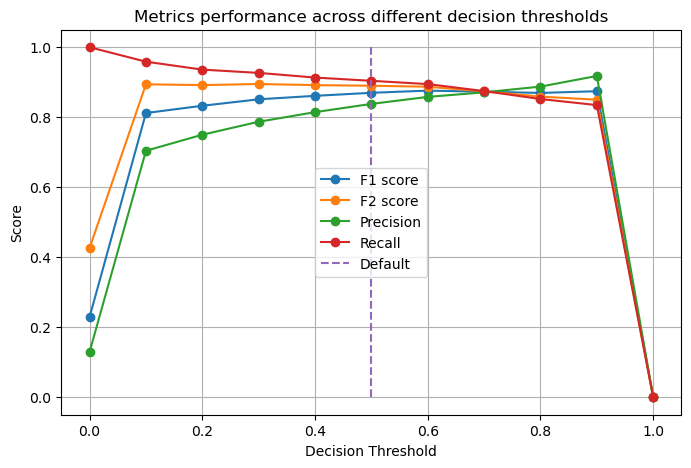

In [38]:
f1=[]
f2=[]
pre=[]
re=[]
lim=[]

for thresh in np.arange(0.0,1.1,0.1):
    y_thresh=(y_final_pred_proba>=thresh).astype(int)
    f1.append(f1_score(y_test,y_thresh))
    f2.append(fbeta_score(y_test,y_thresh,beta=2))
    pre.append(precision_score(y_test,y_thresh))
    re.append(recall_score(y_test,y_thresh))
    lim.append(thresh)

plt.figure(figsize=(8,5))
plt.plot(lim, f1, marker="o", label="F1 score")
plt.plot(lim, f2, marker="o", label="F2 score")
plt.plot(lim, pre, marker="o", label="Precision")
plt.plot(lim, re, marker="o", label="Recall")
plt.plot([0.5,0.5],[0,1],label="Default",linestyle="--")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Metrics performance across different decision thresholds")
plt.legend()
plt.grid(True)

plt.show()

**Default Threshold is selected for optimal performance across all metrics**

In [39]:
print("Final Model Summary")
print("PR score: ",final_pr)
print("---")
print(classification_report(y_test,y_final_pred))
print("---")
print("ROC AUC Score: ",roc_auc_score(y_test,y_final_pred))

Final Model Summary
PR score:  0.9542840946856155
---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5044
           1       0.84      0.90      0.87       750

    accuracy                           0.96      5794
   macro avg       0.91      0.94      0.92      5794
weighted avg       0.97      0.96      0.97      5794

---
ROC AUC Score:  0.9390142743854083


In [41]:
x_train.columns.to_list()

['sensor_9',
 'sensor_14',
 'sensor_9_lag_1',
 'sensor_9_lag_2',
 'sensor_14_lag_1',
 'sensor_14_lag_2',
 'sensor_2_mean_6',
 'sensor_2_std_6',
 'sensor_3_mean_6',
 'sensor_3_std_6',
 'sensor_4_mean_6',
 'sensor_4_std_6',
 'sensor_7_mean_6',
 'sensor_7_std_6',
 'sensor_8_mean_6',
 'sensor_8_std_6',
 'sensor_9_mean_6',
 'sensor_9_std_6',
 'sensor_11_mean_6',
 'sensor_11_std_6',
 'sensor_12_mean_6',
 'sensor_12_std_6',
 'sensor_13_mean_6',
 'sensor_13_std_6',
 'sensor_14_mean_6',
 'sensor_14_std_6',
 'sensor_15_mean_6',
 'sensor_15_std_6',
 'sensor_17_mean_6',
 'sensor_17_std_6',
 'sensor_20_mean_6',
 'sensor_20_std_6',
 'sensor_21_mean_6',
 'sensor_21_std_6',
 'sensor_2_mean_12',
 'sensor_3_mean_12',
 'sensor_4_mean_12',
 'sensor_7_mean_12',
 'sensor_9_mean_12',
 'sensor_11_mean_12',
 'sensor_13_mean_12',
 'sensor_14_mean_12',
 'sensor_15_mean_12',
 'sensor_17_mean_12',
 'sensor_20_mean_12',
 'sensor_21_mean_12',
 'sensor_2_ema_12',
 'sensor_3_ema_12',
 'sensor_7_ema_12',
 'sensor_8_ema

In [42]:
required_sensors= [
    "sensor_2", "sensor_3", "sensor_4", "sensor_7", "sensor_8",
    "sensor_9", "sensor_11", "sensor_12", "sensor_13", "sensor_14",
    "sensor_15", "sensor_17", "sensor_20", "sensor_21"
]

In [44]:
feature_requirements = {
    "sensor_9": {
        "raw": True,
        "lags": [1, 2],
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_14": {
        "raw": True,
        "lags": [1, 2],
        "mean": [6, 12],
        "std": [6],
    },
    "sensor_2": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_3": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_4": {
        "mean": [6, 12],
        "std": [6],
    },
    "sensor_7": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_8": {
        "mean": [6],
        "std": [6],
        "ema": [12],
    },
    "sensor_11": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_12": {
        "mean": [6],
        "std": [6],
    },
    "sensor_13": {
        "mean": [6, 12],
        "std": [6],
    },
    "sensor_15": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_17": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_20": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
    "sensor_21": {
        "mean": [6, 12],
        "std": [6],
        "ema": [12],
    },
}


In [45]:
# Exporting both Model and Features used for Deployment purposes
import os
import joblib

output_dir = "/mnt/f/Zaalima Internship/Zaalima Project/factoryguard-ai/output"
os.makedirs(output_dir, exist_ok=True)

joblib.dump(feature_requirements, os.path.join(output_dir, "features.pkl"))
joblib.dump(final_model, os.path.join(output_dir, "final_model.pkl"))

['/mnt/f/Zaalima Internship/Zaalima Project/factoryguard-ai/output/final_model.pkl']